<a href="https://colab.research.google.com/github/JSJeong-me/Uniinfo-Machine-Vision/blob/main/U0812/kaggle_cv_lec04_the_sliding_window.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np
from itertools import product
from skimage import draw, transform

def circle(size, val=None, r_shrink=0):
    circle = np.zeros([size[0]+1, size[1]+1])
    rr, cc = draw.circle_perimeter(
        size[0]//2, size[1]//2,
        radius=size[0]//2 - r_shrink,
        shape=[size[0]+1, size[1]+1],
    )
    if val is None:
        circle[rr, cc] = np.random.uniform(size=circle.shape)[rr, cc]
    else:
        circle[rr, cc] = val
    circle = transform.resize(circle, size, order=0)
    return circle

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # 형식 커널
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # 도식화 커널
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

def show_extraction(image,
                    kernel,
                    conv_stride=1,
                    conv_padding='valid',
                    activation='relu',
                    pool_size=2,
                    pool_stride=2,
                    pool_padding='same',
                    figsize=(10, 10),
                    subplot_shape=(2, 2),
                    ops=['Input', 'Filter', 'Detect', 'Condense'],
                    gamma=1.0):
    # 레이어 만들기
    model = tf.keras.Sequential([
                    tf.keras.layers.Conv2D(
                        filters=1,
                        kernel_size=kernel.shape,
                        strides=conv_stride,
                        padding=conv_padding,
                        use_bias=False,
                        input_shape=image.shape,
                    ),
                    tf.keras.layers.Activation(activation),
                    tf.keras.layers.MaxPool2D(
                        pool_size=pool_size,
                        strides=pool_stride,
                        padding=pool_padding,
                    ),
                   ])

    layer_filter, layer_detect, layer_condense = model.layers
    kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
    layer_filter.set_weights([kernel])

    # 텐서플로우를 위한 형식 변환
    image = tf.expand_dims(image, axis=0)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) 
    
    # 특성 추출
    image_filter = layer_filter(image)
    image_detect = layer_detect(image_filter)
    image_condense = layer_condense(image_detect)
    
    images = {}
    if 'Input' in ops:
        images.update({'Input': (image, 1.0)})
    if 'Filter' in ops:
        images.update({'Filter': (image_filter, 1.0)})
    if 'Detect' in ops:
        images.update({'Detect': (image_detect, gamma)})
    if 'Condense' in ops:
        images.update({'Condense': (image_condense, gamma)})
    
    # 도식화
    plt.figure(figsize=figsize)
    for i, title in enumerate(ops):
        image, gamma = images[title]
        plt.subplot(*subplot_shape, i+1)
        plt.imshow(tf.image.adjust_gamma(tf.squeeze(image), gamma))
        plt.axis('off')
        plt.title(title)

# 소개  
이전의 포스트들을 통해 이미지에서 특성을 추출하는 세 가지 작용을 살펴보았다.  
1. 합성곱 레이어로 '필터링'하기
2. ReLU 활성화로 '감지'하기
3. 최대 풀링 레이어로 '압축'하기  

합성곱과 풀링은 '슬라이딩 창'을 통해 이루어진다는 공통점을 가진다. 합성곱에서 이 '창'은 커널의 차원(dimension) 파라미터인 kernel_size로 주어진다. 풀링에서는 pool_size로 주어진다.  
<figure>
<img src="https://i.imgur.com/LueNK6b.gif" width=400 alt="A 2D sliding window.">
</figure>  
합성곱과 풀링 레이어 둘 다 영향을 미치는 두 개의 추가적인 파라미터가 있다. 이는 창의 '보폭(stride)'과 이미지의 가장자리에 '패딩(padding)'을 사용할건지의 여부이다. strides 파라미터는 한 번의 작용에 슬라이드 창이 얼마나 움직일지를 뜻하며, padding 파라미터는 입력 이미지의 가장자리 픽셀을 어떻게 처리할지를 의미한다.  
  
이 두 가지 파라미터로 레이어를 구성하면 아래와 같다.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(
        filters = 64,
        kernel_size = 3,
        strides = 1,
        padding = 'same',
        activation = 'relu'),
    layers.MaxPool2D(
        pool_size = 2,
        strides = 1,
        padding = 'same'
    )
    # 더 많은 레이어가 추가될 수 있다.
])

## 보폭(Stride)  
각 단계별로 창이 움직이는 정도를 '보폭'이라고 한다. 우리는 이미지의 모든 차원에 대해 보폭을 정의해야 한다 : 하나는 좌에서 우로, 하나는 위에서 아래로 움직이는 차원이다. 아래 그림을 통해 보폭이 2인 strides = (2,2)의 경우를 확인할 수 있다.  
<figure>
<img src="https://i.imgur.com/Tlptsvt.gif" width=400 alt="Sliding window with a stride of (2, 2).">
</figure>  
보폭은 어떤 효과를 가지고 있을까? 모든 방향으로의 보폭이 1보다 큰 경우, 슬라이드 창은 입력 이미지에서의 일부 픽셀을 건너뛰게 된다.   
우리는 분류를 위한 최적의 특징을 원하기 때문에 합성곱 레이어는 대부분 stride = (1,1)이다. 보폭을 늘이는 것은 곧 풀링 과정에서 중요할수도 있는 정보를 잃을 수 있음을 의미하기 때문이다. 그러나 최대 풀링 레이어는 거의 항상 (2,2) 또는 (3,3)처럼 1보다 큰 보폭을 가진다. 당연히 슬라이드 창 그 자체보다 큰 크기의 보폭을 가지지는 않는다.  
  
  마지막으로 보폭의 크기가 양쪽 방향으로 동일하다면, strides = (2,2) 대신 strides = 2라고 적는 것처럼 튜플이 아닌 숫자 하나로만 보폭을 정의할 수 있다.

## 패딩  
슬라이드 창을 적용할 때에 입력 이미지의 가장자리를 어떻게 처리할지에 대한 의문이 생긴다. 입력 이미지의 안에만 머무른다면 창이 절대 가장자리 픽셀에 대해 풀링 등의 작용을 할 수 없다. 모든 픽셀을 동일하게 처리하지 않으니 문제가 생기지 않을까?  
  
  합성곱이 이 '가장자리 픽셀'들에 대해 어떻게 처리하는지는 'padding' 파라미터로 정의한다. 텐서플로우에서는 두 가지 선택지가 있다 : 'padding ='same'' 또는 'padding = 'valid''. 둘은 서로 상충 관계에 놓여있다.  
    
  padding = 'valid'으로 설정하면, 합성곱 창은 온전히 이미지 입력값 내부에 머무른다. 단점은 가장자리 픽셀을 읽지 못하여 출력값의 크기가 줄어들고, 커널이 클수록 더 줄어든다는 것이다. 이는 특히 입력값의 크기가 작을 때 신경망에서 레이어의 개수를 제한할 것이다.  
  반대는 padding = 'same'을 사용하는 것이다. 여기서는 입력값의 가장자리 주변을 0값의 픽셀로 '패딩'을 한다. 즉, 0값의 픽셀만 사용하여 출력값이 입력값과 크기가 동일하도록 하는 것이다. 그러나 이는 가장자리 픽셀의 영향을 희석시키는 효과가 있다. 아래 그림은 'same' 패딩을 사용한 슬라이드 창의 모습을 보인다.  
  <figure>
<img src="https://i.imgur.com/RvGM2xb.gif" width=400 alt="Illustration of zero (same) padding.">
</figure>  
우리가 보고 있던 VGG 모델은 모든 합성곱 레이어에 'same' 패딩을 적용한다. 대부분 현대의 합성곱 레이어는 'same'과 'valid' 패딩을 적절히 혼합하여 사용한다. (그리고 다른 파라미터로 튜닝한다)

# 예시 - 슬라이드 창  
슬라이드 창 파라미터의 효과를 더 알아보기 위해선, 각 픽셀이 보이는 저해상도 이미지로 특성 추출 과정을 따라가보는 것이 도움이 된다. 간단한 원을 살펴보자.  
  
  아래의 셀이 이미지와 커널을 정의할 것이다.

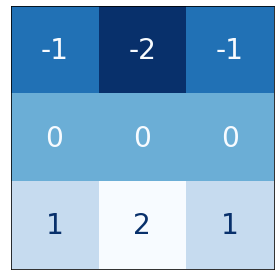

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
      titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image = circle([64,64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])

kernel = tf.constant([
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]
])
show_kernel(kernel)

VGG 구조는 꽤나 간단하다. 합성곱의 보폭이 1, 창 크기가 2X2이고 보폭이 2인 최대 풀링을 사용한다. visiontools의 함수를 사용하여 각 단계를 시각화할 것이다.

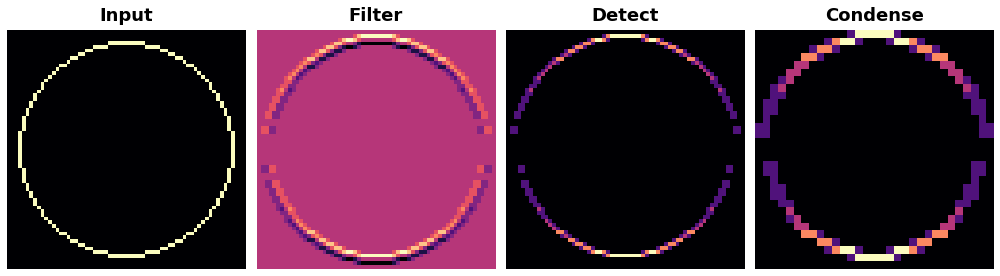

In [4]:
show_extraction(
    image, kernel,
    
    # 창 파라미터
    conv_stride = 1,
    pool_size = 2,
    pool_stride = 2,
    
    subplot_shape = (1,4),
    figsize = (14,6),
)

위 코드는 잘 작동한다! 해당 커널은 수평선을 감지하도록 설계되었고, 출력되는 특징 맵에서 입력값의 수평 요소가 '가장 많은' 활성화를 불러일으킨다는 것을 확인할 수 있다.  
  
  합성곱의 보폭을 3으로 바꾸면 어떻게 될까?

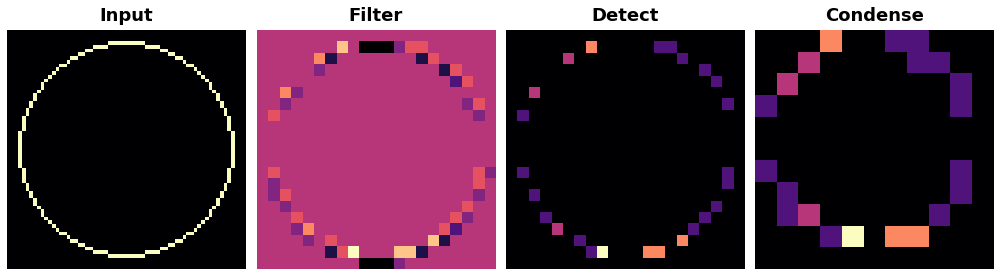

In [5]:
show_extraction(
    image, kernel,
    
    # 창 파라미터
    conv_stride = 3,
    pool_size = 2,
    pool_stride = 2,
    
    subplot_shape = (1,4),
    figsize = (14,6)
)

이는 추출되는 특성의 질을 낮추는 것으로 보인다. 입력되는 원은 1 픽셀 정도의 두께이므로 꽤나 '디테일하다'고 할 수 있다. 그러니 보폭 3의 합성곱은 좋은 특성 맵을 추출하기엔 부족하였을 것이다.  
  
  가끔, 모델은 입력 레이어에서 큰 보폭으로 합성곱을 적용하기도 한다. 대부분 이런 경우엔 커널의 크기도 크다. 예를 들어 ResNet50 모델은 첫 번째 레이어에서 보폭 2의 7X7 크기의 커널을 사용한다. 이는 큰 규모의 특징을 너무 많은 입력값 정보를 잃지 않으면서도 빠르게 추출할 수 있도록 한다.

# 결론  
여기선 합성곱과 풀링 모두에서 공통적으로 사용되는 계산 기법인 '슬라이드 창'과 그에 영향을 미치는 파라미터를 살펴보았다. 이런 방식의 계산은 합성곱 신경망의 가장 큰 특징 중 하나이다.